In [115]:
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
np.random.seed(0)

In [116]:
df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [117]:
df['num_char'] = df['text'].apply(lambda x: len(x))
df['num_words'] = df['text'].apply(lambda x: len(x.split()))

# Filling in Keyword Nulls

In [118]:
#grab all #hashtags in a list
df.loc[df['keyword'].isna(),'hashtags'] = df['text'].apply(lambda x: [i[1:] for i in x.split() if '#' in i])

#create a set of all values in keyword column
keywords = set(df[~df.keyword.isna()].keyword.values)

In [119]:
#narrow down the list list of all hashtags in keywords
df['new_tag'] = df.hashtags.apply(lambda x: [i.lower() for i in x if i in keywords] if type(x) == list else np.nan)

#drop empty lists
df['new_tag'] = df['new_tag'].apply(lambda x: x if x != [] and x != np.nan else np.nan)

#grab the first hashtag and fill in missing values
df['new_tag'] = df['new_tag'].apply(lambda x: x[0] if type(x) == list else np.nan)
df.loc[df.keyword.isna(), 'keyword'] = df['new_tag']

In [120]:
#drop old columns
df.drop(['new_tag','hashtags'],inplace=True, axis=1)

# Removing Weird Locations

In [121]:
#get rid of weird characters and blank spaces
characters= ['?','/', '#','+']
df['location'] = df.location.apply(lambda x: x if not any([char in str(x) for char in characters]) else np.nan)
df['location'] = df.location.apply(lambda x: x if type(x) != str else (x if x.strip() != '' else np.nan))


In [122]:
#get rid of locations with numbers
df['location'] = df.location.apply(lambda x: x if not any([i.isdigit() for i in str(x)]) else np.nan)

In [123]:
#get rid of locations with 4 or more words
df['location'] = df.location.apply(lambda x: x if type(x) != str else (x if len(x.split()) < 4 else np.nan))

In [124]:
bad_abbrev_and_words = ['Earth','Worldwide','Everywhere','Reddit','World','Global','ava','EIC','HTX', 'ATX','atx','PDX','MNL','CLT', 'NBO', 'AEP','mnl', 'ayr', 'GCC', 'Htx','wny', 'VCU', 'Orm', 'DMV','Ktx',]
df['location'] = df.location.apply(lambda x: x if x not in bad_abbrev_and_words else np.nan)


In [125]:
df.loc[df.groupby('location').location.transform('count') == 1,'location'] = np.nan

# Filling in Location Nulls

In [126]:
#split into two differnt columns for upper case abbreviations and lower case for words
df['new_loc_lower'] = df.text.apply(lambda x: [i.lower().strip() for i in x.split() if len(i) > 2])
df['new_loc_upper'] = df.text.apply(lambda x: [i.upper().strip() for i in x.split() if len(i) <= 2])

In [127]:
#remove all blank strings from both
df['new_loc_lower'] = df.new_loc_lower.apply(lambda x: x if '' not in x else np.nan)
df['new_loc_upper'] = df.new_loc_upper.apply(lambda x: x if '' not in x else np.nan)

#remove all empty lists from both
df['new_loc_lower'] = df.new_loc_lower.apply(lambda x: x if x != [] else np.nan)
df['new_loc_upper'] = df.new_loc_upper.apply(lambda x: x if x != [] else np.nan)

In [128]:
#create a unique list of locations for both upper and lower
x = list(df.location.unique())[1:]
key_down = [i.lower() for i in x if len(i) > 2]
key_up = [i.upper() for i in x if len(i) <= 2]

In [129]:
#remove all words that arnt in either key_up or key_down
df['new_loc_lower'] = df.new_loc_lower.apply(lambda x: [i.lower() for i in x if i.lower() in key_down] if type(x) == list else np.nan)
df['new_loc_upper'] = df.new_loc_upper.apply(lambda x: [i.upper() for i in x if i.upper() in key_up] if type(x) == list else np.nan)


In [130]:
#remove common 2 letter words from initials
bad_initials = ['IN','ON', 'OK']
df['new_loc_upper'] = df.new_loc_upper.apply(lambda x: [i for i in x if i not in bad_initials] if type(x) == list else np.nan)

#remove empty lists and grab the first element in each list
df['new_loc_upper'] = df.new_loc_upper.apply(lambda x: x if x != [] else np.nan)
df['new_loc_upper'] = df.new_loc_upper.apply(lambda x: x[0] if type(x) == list else x)

In [131]:
#remove empty lists
df['new_loc_lower'] = df.new_loc_lower.apply(lambda x: x if x != [] else np.nan)

#if only element in list grab that element
df['new_loc_lower'] = df.new_loc_lower.apply(lambda x: x if type(x) != list else (x[0] if len(x) == 1 else x))

#if element repeats in list grab that element
df['new_loc_lower'] = df.new_loc_lower.apply(lambda x: x if type(x) != list else (x[0] if x[0] in x[1:] else x))

In [132]:
bad_places = ['west','east','north','south', 'mass', 'hell','heaven', 'global','world', 'unknown', 'earth', 'ebola', 'nowhere','studio', 'lincoln']

#remove all words in bad_places for lists
df['new_loc_lower'] = df.new_loc_lower.apply(lambda x: [i for i in x if i not in bad_places] if type(x) == list else x)

#remove all words in bad_places for strings
df['new_loc_lower'] = df.new_loc_lower.apply(lambda x: x if type(x) != str else(x if x not in bad_places else np.nan))

#set empty lists to NaN and grab the first element in each list
df['new_loc_lower'] = df.new_loc_lower.apply(lambda x: x if x != [] else np.nan)
df['new_loc_lower'] = df.new_loc_lower.apply(lambda x: x[0] if type(x) == list else x)

In [133]:
#set 2 digit location first since more common, then words
df.loc[df['location'].isna(),'location'] = df.loc[df['location'].isna(),'new_loc_upper']
df.loc[df['location'].isna(),'location'] = df.loc[df['location'].isna(),'new_loc_lower']

In [134]:
df.drop(['new_loc_lower','new_loc_upper'],inplace=True,axis=1)

In [135]:
df.loc[df.groupby('location').location.transform('count') == 1, 'location'] = 'Missing'

In [137]:
#taking the second location in each location with two specified
df['location'] = df['location'].apply(lambda x: x if type(x) != str else x.split(', ')[1] if ', ' in x else x)

In [138]:
#removing .
df['location'] = df['location'].apply(lambda x: x if type(x) != str else  ''.join(x.split('.')) if '.' in x else x)

#capitalize 
df['location'] = df['location'].apply(lambda x: x.title() if type(x) == str else x)

In [139]:
df.loc[df.groupby('location').location.transform('count') < 11,'location'] = 'ten_or_less'

In [140]:
df.location.fillna('Missing', inplace=True)
df.keyword.fillna('Missing', inplace=True)

In [162]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ["''", '""', '...', '``', 'http', 'https']

def process_tweet(tweet):
    tokenized_tweet = nltk.word_tokenize(tweet)
    clean_results = [w.lower() for w in tokenized_tweet if not w.lower() in stopwords_list and not 't.co/' in w.lower()]
    return clean_results

In [163]:
processed_data = list(map(process_tweet, df.text))
df['tokenized_text'] = processed_data

In [164]:
total_vocab = set()
for i in processed_data:
    total_vocab.update(i)
len(total_vocab)
total_wordcount = len(total_vocab)

18443

In [165]:
tweets_concat = []
for i in processed_data:
    tweets_concat+=i

In [166]:
tweets_freqdist = FreqDist(tweets_concat)
tweets_freqdist.most_common(20)

[("'s", 791),
 ("n't", 446),
 ('like', 345),
 ('amp', 344),
 ("'m", 250),
 ('fire', 249),
 ('get', 228),
 ('new', 219),
 ('via', 218),
 ('people', 197),
 ('news', 197),
 ('one', 194),
 ('video', 165),
 ('2', 162),
 ('emergency', 155),
 ('disaster', 153),
 ('would', 141),
 ('police', 138),
 ("'re", 129),
 ('still', 128)]

In [168]:
target = df.target
features = df.drop(columns=['target','id'])

In [169]:
X_train,X_test, y_train,y_test = train_test_split(features,target,test_size = 0.2,random_state = 2)

In [170]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
vectorizer = TfidfVectorizer()

In [15]:
X_train.head()

,keyword,location,text,length_of_tweet,tokenized_text
4549,injured,USA,Offers : http://t.co/Gl3C1vc88P #8392 Deluxe T...,139,"[offers, 8392, deluxe, toilet, safety, support..."
4512,hurricane,NaN,The hurricane mixxtail kinda tastes like the w...,87,"[hurricane, mixxtail, kinda, tastes, like, wat..."
4368,hijacker,NaN,Complete Solution to Get Rid of http://t.co/9C...,117,"[complete, solution, get, rid, ûò, browser, h..."
4297,hellfire,NaN,@HellFire_eV @JackPERU1 then I do this to one ...,58,"[hellfire_ev, jackperu1, one]"
13,NaN,NaN,#Flood in Bago Myanmar #We arrived Bago,39,"[flood, bago, myanmar, arrived, bago]"


In [16]:
tf_idf_data_train = vectorizer.fit_transform(X_train.text)

tf_idf_data_test = vectorizer.transform(X_test.text)

In [17]:
tf_idf_data_train.shape

(6090, 18449)

In [18]:
non_zero_cols = tf_idf_data_train.nnz / float(tf_idf_data_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Tweets: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tf_idf_data_train.shape[1]))
print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Tweets: 14.652709359605911
Percentage of columns containing 0: 0.9992057721632822


In [19]:
df = df.drop(columns=['tokenized_text','id'])

In [20]:
df.head()

,keyword,location,text,target,length_of_tweet
0,earthquake,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [21]:
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier(n_estimators=100)

nb_classifier.fit(tf_idf_data_train, y_train)
nb_train_preds = nb_classifier.predict(tf_idf_data_train)
nb_test_preds = nb_classifier.predict(tf_idf_data_test)

In [22]:
rf_classifier.fit(tf_idf_data_train, y_train)
rf_train_preds = rf_classifier.predict(tf_idf_data_train)
rf_test_preds = rf_classifier.predict(tf_idf_data_test)

In [23]:
nb_train_score = accuracy_score(y_train, nb_train_preds)
nb_test_score = accuracy_score(y_test, nb_test_preds)
rf_train_score = accuracy_score(y_train, rf_train_preds)
rf_test_score = accuracy_score(y_test, rf_test_preds)

print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))
print("")
print('-'*70)
print("")
print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_train_score, rf_test_score))

Multinomial Naive Bayes
Training Accuracy: 0.8892 		 Testing Accuracy: 0.7912

----------------------------------------------------------------------

Random Forest
Training Accuracy: 0.9969 		 Testing Accuracy: 0.7781


# Bag of Words

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
#tokenizer to remove unwanted elements from out data like symbols and numbers
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(df['text'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    text_counts, df['target'], test_size=0.3, random_state=1)

In [8]:
rf_clf = RandomForestClassifier().fit(X_train, y_train)
predicted= rf_clf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, predicted))

/Users/reuben/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Accuracy: 0.7810858143607706


In [54]:
tf=TfidfVectorizer()
text_tf = tf.fit_transform(df['text'])

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    text_tf, df['target'], test_size=0.3, random_state=1)

In [56]:
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:", accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.7964098073555166


In [65]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score


In [260]:
rf_param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf" : [1, 3, 6, 9],
    "n_estimators" : [10, 30, 100, 150, 200]
}

In [261]:
import time
start = time.time()
rf_grid_search = GridSearchCV(rf_clf,rf_param_grid,cv=3)
rf_grid_search.fit(X_train, y_train)

print("Testing Accuracy: {:.4}%".format(rf_grid_search.best_score_ * 100))
print("Total Runtime for Grid Search on Random Forest Classifier: {:.4} seconds".format(time.time() - start))
print("")
print("Optimal Parameters: {}".format(rf_grid_search.best_params_))

Testing Accuracy: 78.06%
Total Runtime for Grid Search on Random Forest Classifier: 3.172e+03 seconds

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 150}


In [69]:
adaboost_clf = AdaBoostClassifier()
adaboost_clf.fit(X_train, y_train)
adaboost_mean_cv_score = np.mean(cross_val_score(adaboost_clf,X_train,y_train,cv=3))

print("Mean Cross Validation Score for AdaBoost: {:.4}%".format(adaboost_mean_cv_score * 100))

Mean Cross Validation Score for AdaBoost: 73.02%


In [70]:
adaboost_param_grid = {
    "n_estimators": [50, 100, 250],
    "learning_rate": [1.0, 0.5, 0.1]
}

In [71]:
adaboost_grid_search = GridSearchCV(adaboost_clf,adaboost_param_grid,cv=3)
adaboost_grid_search.fit(X_train, y_train)

print("Testing Accuracy: {:.4}%".format(adaboost_grid_search.best_score_ * 100))
print("Total Runtime for Grid Search on AdaBoost: {:.4} seconds".format(time.time() - start))
print("")
print("Optimal Parameters: {}".format(adaboost_grid_search.best_params_))

Testing Accuracy: 75.55%
Total Runtime for Grid Search on AdaBoost: 854.7 seconds

Optimal Parameters: {'learning_rate': 0.5, 'n_estimators': 250}


In [14]:
data = df['text'].map(word_tokenize).values

In [15]:
def process_tweet(tweet):
    tokenized_tweet = nltk.word_tokenize(tweet)
    clean_results = [w.lower() for w in tokenized_tweet if not w.lower() in stopwords_list and not 't.co/' in w.lower()]
    return clean_results

In [16]:
total_vocabulary = set(word for headline in data for word in headline)
print("There are {} unique tokens in the dataset.".format(len(total_vocabulary)))

There are 27285 unique tokens in the dataset.


In [17]:
glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [18]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note from Mike: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # It can't be used in a sklearn Pipeline. 
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [19]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

rf =  Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
              ("Random Forest", RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression())])

In [20]:
models = [('Random Forest', rf)]
#           ("Support Vector Machine", svc),
#           ("Logistic Regression", lr)]

In [23]:
scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [24]:
scores

[('Random Forest', 0.7324304483223025)]

# Deep Learning w/ Word Embeddings

In [355]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.optimizers import Adam, SGD

In [390]:
tokenizer = text.Tokenizer(num_words=5000)
tokenizer.fit_on_texts(list(df.text))
list_tokenized_tweets = tokenizer.texts_to_sequences(df.text)
X_t = sequence.pad_sequences(list_tokenized_tweets, maxlen=20)

In [391]:
y = pd.get_dummies(target).values

In [392]:
embedding_size = 32
input_ = Input(shape=(20,))
x = Embedding(5000, embedding_size)(input_)
x = LSTM(100, return_sequences=True)(x)
x = Dropout(0.5)(x)
x = Dense(50, kernel_regularizer=regularizers.l2(0.5))(x)
x = Dropout(0.5)(x)
x = Dense(25)(x)
x = Dropout(0.5)(x)
x = Dense(25)(x)
x = Dropout(0.5)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(50, kernel_regularizer=regularizers.l2(0.5))(x)
x = Dropout(0.5)(x)
# There are 2 different possible classes, so we use 2 neurons in our output layer
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_, outputs=x)

In [393]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00005), metrics=['accuracy'])

In [394]:
model.summary()

Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        (None, 20)                0         
_________________________________________________________________
embedding_45 (Embedding)     (None, 20, 32)            160000    
_________________________________________________________________
lstm_45 (LSTM)               (None, 20, 100)           53200     
_________________________________________________________________
dropout_112 (Dropout)        (None, 20, 100)           0         
_________________________________________________________________
dense_148 (Dense)            (None, 20, 50)            5050      
_________________________________________________________________
dropout_113 (Dropout)        (None, 20, 50)            0         
_________________________________________________________________
dense_149 (Dense)            (None, 20, 25)            127

/Users/reuben/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6090 samples, validate on 1523 samples
Epoch 1/400
6090/6090 [==============================] - 5s 816us/step - loss: 49.9562 - accuracy: 0.5177 - val_loss: 48.9281 - val_accuracy: 0.5345
Epoch 2/400
6090/6090 [==============================] - 4s 655us/step - loss: 47.9551 - accuracy: 0.5560 - val_loss: 46.9724 - val_accuracy: 0.5345
Epoch 3/400
6090/6090 [==============================] - 4s 692us/step - loss: 46.0357 - accuracy: 0.5622 - val_loss: 45.0913 - val_accuracy: 0.5345
Epoch 4/400
6090/6090 [==============================] - 4s 679us/step - loss: 44.1896 - accuracy: 0.5637 - val_loss: 43.2850 - val_accuracy: 0.5345
Epoch 5/400
6090/6090 [==============================] - 4s 653us/step - loss: 42.4177 - accuracy: 0.5759 - val_loss: 41.5493 - val_accuracy: 0.5345
Epoch 6/400
6090/6090 [==============================] - 4s 670us/step - loss: 40.7156 - accuracy: 0.5752 - val_loss: 39.8809 - val_accuracy: 0.5345
Epoch 7/400
6090/6090 [==============================] - 4

6090/6090 [==============================] - 4s 584us/step - loss: 3.9762 - accuracy: 0.8911 - val_loss: 4.1851 - val_accuracy: 0.7393
Epoch 56/400
6090/6090 [==============================] - 3s 571us/step - loss: 3.7606 - accuracy: 0.8952 - val_loss: 3.9755 - val_accuracy: 0.7380
Epoch 57/400
6090/6090 [==============================] - 4s 580us/step - loss: 3.5521 - accuracy: 0.8982 - val_loss: 3.7915 - val_accuracy: 0.7406
Epoch 58/400
6090/6090 [==============================] - 3s 574us/step - loss: 3.3659 - accuracy: 0.8908 - val_loss: 3.6023 - val_accuracy: 0.7341
Epoch 59/400
6090/6090 [==============================] - 4s 577us/step - loss: 3.1733 - accuracy: 0.9007 - val_loss: 3.4216 - val_accuracy: 0.7380
Epoch 60/400
6090/6090 [==============================] - 3s 574us/step - loss: 2.9925 - accuracy: 0.9036 - val_loss: 3.2660 - val_accuracy: 0.7393
Epoch 61/400
6090/6090 [==============================] - 4s 592us/step - loss: 2.8266 - accuracy: 0.9049 - val_loss: 3.1030 

6090/6090 [==============================] - 4s 702us/step - loss: 0.2510 - accuracy: 0.9401 - val_loss: 0.7833 - val_accuracy: 0.7157
Epoch 111/400
6090/6090 [==============================] - 4s 698us/step - loss: 0.2548 - accuracy: 0.9379 - val_loss: 0.7516 - val_accuracy: 0.7118
Epoch 112/400
6090/6090 [==============================] - 4s 661us/step - loss: 0.2456 - accuracy: 0.9420 - val_loss: 0.7590 - val_accuracy: 0.7124
Epoch 113/400
6090/6090 [==============================] - 4s 614us/step - loss: 0.2416 - accuracy: 0.9406 - val_loss: 0.7612 - val_accuracy: 0.7118
Epoch 114/400
6090/6090 [==============================] - 4s 612us/step - loss: 0.2362 - accuracy: 0.9397 - val_loss: 0.7631 - val_accuracy: 0.7111
Epoch 115/400
6090/6090 [==============================] - 5s 787us/step - loss: 0.2255 - accuracy: 0.9440 - val_loss: 0.7592 - val_accuracy: 0.7242
Epoch 116/400
6090/6090 [==============================] - 4s 684us/step - loss: 0.2233 - accuracy: 0.9432 - val_loss: 0

6090/6090 [==============================] - 4s 732us/step - loss: 0.1559 - accuracy: 0.9521 - val_loss: 0.8566 - val_accuracy: 0.7111
Epoch 166/400
6090/6090 [==============================] - 4s 687us/step - loss: 0.1502 - accuracy: 0.9560 - val_loss: 0.8558 - val_accuracy: 0.7118
Epoch 167/400
6090/6090 [==============================] - 5s 758us/step - loss: 0.1495 - accuracy: 0.9530 - val_loss: 0.8728 - val_accuracy: 0.7039
Epoch 168/400
6090/6090 [==============================] - 5s 740us/step - loss: 0.1544 - accuracy: 0.9534 - val_loss: 0.8440 - val_accuracy: 0.7072
Epoch 169/400
6090/6090 [==============================] - 4s 675us/step - loss: 0.1529 - accuracy: 0.9567 - val_loss: 0.8799 - val_accuracy: 0.6947
Epoch 170/400
6090/6090 [==============================] - 6s 964us/step - loss: 0.1582 - accuracy: 0.9534 - val_loss: 0.8390 - val_accuracy: 0.7104
Epoch 171/400
6090/6090 [==============================] - 5s 875us/step - loss: 0.1527 - accuracy: 0.9539 - val_loss: 0

6090/6090 [==============================] - 4s 603us/step - loss: 0.1227 - accuracy: 0.9604 - val_loss: 1.0086 - val_accuracy: 0.7052
Epoch 221/400
6090/6090 [==============================] - 4s 586us/step - loss: 0.1228 - accuracy: 0.9619 - val_loss: 0.9671 - val_accuracy: 0.7039
Epoch 222/400
6090/6090 [==============================] - 4s 584us/step - loss: 0.1252 - accuracy: 0.9614 - val_loss: 0.9596 - val_accuracy: 0.7058
Epoch 223/400
6090/6090 [==============================] - 4s 580us/step - loss: 0.1151 - accuracy: 0.9627 - val_loss: 1.0934 - val_accuracy: 0.6986
Epoch 224/400
6090/6090 [==============================] - 4s 582us/step - loss: 0.1245 - accuracy: 0.9603 - val_loss: 1.0183 - val_accuracy: 0.6980
Epoch 225/400
6090/6090 [==============================] - 4s 590us/step - loss: 0.1204 - accuracy: 0.9640 - val_loss: 1.0029 - val_accuracy: 0.6980
Epoch 226/400
6090/6090 [==============================] - 4s 582us/step - loss: 0.1253 - accuracy: 0.9604 - val_loss: 0

6090/6090 [==============================] - 4s 584us/step - loss: 0.1037 - accuracy: 0.9673 - val_loss: 1.1299 - val_accuracy: 0.6967
Epoch 276/400
6090/6090 [==============================] - 4s 587us/step - loss: 0.1038 - accuracy: 0.9677 - val_loss: 1.1485 - val_accuracy: 0.6881
Epoch 277/400
6090/6090 [==============================] - 4s 581us/step - loss: 0.1035 - accuracy: 0.9667 - val_loss: 1.0721 - val_accuracy: 0.6986
Epoch 278/400
6090/6090 [==============================] - 4s 588us/step - loss: 0.1050 - accuracy: 0.9644 - val_loss: 1.0921 - val_accuracy: 0.6868
Epoch 279/400
6090/6090 [==============================] - 4s 584us/step - loss: 0.0990 - accuracy: 0.9673 - val_loss: 1.1399 - val_accuracy: 0.6993
Epoch 280/400
6090/6090 [==============================] - 4s 580us/step - loss: 0.1015 - accuracy: 0.9660 - val_loss: 1.1076 - val_accuracy: 0.7019
Epoch 281/400
6090/6090 [==============================] - 4s 578us/step - loss: 0.1094 - accuracy: 0.9670 - val_loss: 1

6090/6090 [==============================] - 4s 579us/step - loss: 0.0915 - accuracy: 0.9690 - val_loss: 1.2432 - val_accuracy: 0.6894
Epoch 331/400
6090/6090 [==============================] - 4s 586us/step - loss: 0.0911 - accuracy: 0.9704 - val_loss: 1.2222 - val_accuracy: 0.6927
Epoch 332/400
6090/6090 [==============================] - 4s 585us/step - loss: 0.0953 - accuracy: 0.9691 - val_loss: 1.1959 - val_accuracy: 0.6907
Epoch 333/400
6090/6090 [==============================] - 4s 581us/step - loss: 0.0896 - accuracy: 0.9700 - val_loss: 1.2819 - val_accuracy: 0.6960
Epoch 334/400
6090/6090 [==============================] - 4s 584us/step - loss: 0.0940 - accuracy: 0.9696 - val_loss: 1.2171 - val_accuracy: 0.6848
Epoch 335/400
6090/6090 [==============================] - 4s 589us/step - loss: 0.0912 - accuracy: 0.9688 - val_loss: 1.1946 - val_accuracy: 0.6927
Epoch 336/400
6090/6090 [==============================] - 4s 582us/step - loss: 0.0912 - accuracy: 0.9708 - val_loss: 1

6090/6090 [==============================] - 3s 556us/step - loss: 0.0794 - accuracy: 0.9727 - val_loss: 1.4635 - val_accuracy: 0.6770
Epoch 386/400
6090/6090 [==============================] - 4s 580us/step - loss: 0.0832 - accuracy: 0.9721 - val_loss: 1.4146 - val_accuracy: 0.6691
Epoch 387/400
6090/6090 [==============================] - 3s 566us/step - loss: 0.0854 - accuracy: 0.9711 - val_loss: 1.3554 - val_accuracy: 0.6855
Epoch 388/400
6090/6090 [==============================] - 3s 558us/step - loss: 0.0800 - accuracy: 0.9716 - val_loss: 1.3923 - val_accuracy: 0.6855
Epoch 389/400
6090/6090 [==============================] - 3s 559us/step - loss: 0.0857 - accuracy: 0.9722 - val_loss: 1.3859 - val_accuracy: 0.6724
Epoch 390/400
6090/6090 [==============================] - 3s 560us/step - loss: 0.0839 - accuracy: 0.9711 - val_loss: 1.3889 - val_accuracy: 0.6822
Epoch 391/400
6090/6090 [==============================] - 3s 561us/step - loss: 0.0827 - accuracy: 0.9729 - val_loss: 1

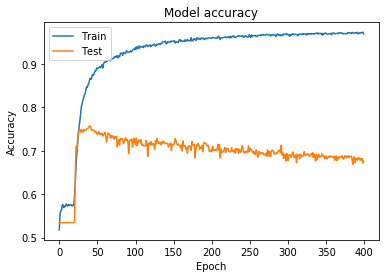

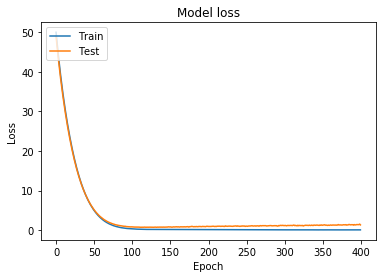

In [395]:
history = model.fit(X_t, target, epochs=400, batch_size=100, validation_split=0.2)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

 # Submission Stuff

## tf-idf MNB and RF submission

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')

In [25]:
vectorizer2 = TfidfVectorizer()

In [26]:
df.head()

,keyword,location,text,target,length_of_tweet
0,earthquake,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [27]:
tf_idf_data_train2 = vectorizer2.fit_transform(df.text)

tf_idf_data_test2 = vectorizer2.transform(test_df.text)

In [28]:
nb_classifier2 = MultinomialNB()

nb_classifier2.fit(tf_idf_data_train2, df.target)
nb_train_preds2 = nb_classifier2.predict(tf_idf_data_train2)
nb_test_preds2 = nb_classifier2.predict(tf_idf_data_test2)

In [264]:
rf_classifier2 = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_leaf=3, min_samples_split=10, n_estimators=150)

rf_classifier2.fit(tf_idf_data_train2, df.target)
rf_train_preds2 = rf_classifier2.predict(tf_idf_data_train2)
rf_test_preds2 = rf_classifier2.predict(tf_idf_data_test2)

In [266]:
sample_submission['target'] = rf_test_preds2

In [267]:
sample_submission.set_index('id', inplace=True)

KeyError: 'id'

In [269]:
sample_submission.to_csv('submission2')

## NN w/ word embeddings submission

In [ ]:
tokenizer_test = text.Tokenizer(num_words=500)
tokenizer_test.fit_on_texts(list(test_df.text))
list_tokenized_tweets_test = tokenizer_test.texts_to_sequences(test_df.text)
testX_t = sequence.pad_sequences(list_tokenized_tweets_test, maxlen=100)

In [ ]:
nn_pred = model.predict(testX_t)

y_classes = nn_pred.argmax(axis=-1)

In [225]:
sample_submission1.target = y_classes
sample_submission1.head()

,target
id,
0,1
2,0
3,0
9,0
11,0


In [226]:
sample_submission1.to_csv('submission1')